In [1]:
!pip install qiskit
!pip install qiskit-aer


[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Deutsch Algorithm using Qiskit 2.x
# Compatible with Qiskit 2.0+ (2024–2025)

from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Statevector
from qiskit_aer import AerSimulator

# Choose the function type: 'constant_0', 'constant_1', 'balanced_0', 'balanced_1'
function_type = 'balanced_1'

def deutsch_oracle(qc, function_type):
    """Implements oracle Uf for given function type."""
    if function_type == 'constant_0':
        # f(x)=0 → Do nothing
        pass
    elif function_type == 'constant_1':
        # f(x)=1 → Apply X on the output qubit
        qc.x(1)
    elif function_type == 'balanced_0':
        # f(x)=x → Apply CNOT (control: input, target: output)
        qc.cx(0, 1)
    elif function_type == 'balanced_1':
        # f(x)=NOT(x) → Apply X, then CNOT, then X
        qc.x(0)
        qc.cx(0, 1)
        qc.x(0)

In [3]:
# Step 1: Initialize quantum circuit with 2 qubits and 1 classical bit
qc = QuantumCircuit(2, 1)

# Step 2: Initialize |x>|y> = |0>|1> and apply Hadamard
qc.x(1)             # Set output qubit to |1>
qc.barrier()
qc.h([0, 1])        # Apply Hadamard to both qubits

# Step 3: Apply the oracle
qc.barrier()
deutsch_oracle(qc, function_type)

In [4]:
# Step 4: Apply Hadamard to input qubit
qc.barrier()
qc.h(0)

# Step 5: Measure the first qubit
qc.measure(0, 0)

# Visualize circuit
print(qc.draw(output="text"))

           ░ ┌───┐ ░ ┌───┐     ┌───┐ ░ ┌───┐┌─┐
q_0: ──────░─┤ H ├─░─┤ X ├──■──┤ X ├─░─┤ H ├┤M├
     ┌───┐ ░ ├───┤ ░ └───┘┌─┴─┐└───┘ ░ └───┘└╥┘
q_1: ┤ X ├─░─┤ H ├─░──────┤ X ├──────░───────╫─
     └───┘ ░ └───┘ ░      └───┘      ░       ║ 
c: 1/════════════════════════════════════════╩═
                                             0 


In [5]:
# Step 6: Simulate
sim = AerSimulator()
qc_compiled = transpile(qc, sim)
result = sim.run(qc_compiled).result()
counts = result.get_counts()

print("\nMeasurement results:", counts)

# Interpret result
if list(counts.keys())[0] == '0':
    print("→ Function is CONSTANT.")
else:
    print("→ Function is BALANCED.")


Measurement results: {'1': 1024}
→ Function is BALANCED.


In [ ]:
# Task_1 : Custom Oracle Design

In [ ]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator

# Changed to (x XOR 1) function
function_type = 'xor_1'

def deutsch_oracle(qc, function_type):
    if function_type == 'xor_1':
        qc.x(0)
        qc.cx(0, 1)
        qc.x(0)

qc = QuantumCircuit(2, 1)
qc.x(1)
qc.h([0, 1])
deutsch_oracle(qc, function_type)
qc.h(0)
qc.measure(0, 0)

sim = AerSimulator()
qc_compiled = transpile(qc, sim)
result = sim.run(qc_compiled).result()
counts = result.get_counts()
print(qc.draw(output="text"))
print("\nMeasurement results:", counts)
print("→ Function is BALANCED.")


     ┌───┐┌───┐     ┌───┐┌───┐┌─┐
q_0: ┤ H ├┤ X ├──■──┤ X ├┤ H ├┤M├
     ├───┤├───┤┌─┴─┐└───┘└───┘└╥┘
q_1: ┤ X ├┤ H ├┤ X ├───────────╫─
     └───┘└───┘└───┘           ║ 
c: 1/══════════════════════════╩═
                               0 

Measurement results: {'1': 1024}
→ Function is BALANCED.


In [ ]:
'''
The function f(x) = x XOR 1 is detected as BALANCED.
'''

In [ ]:
# Task_2 : Bloch Sphere Visualization

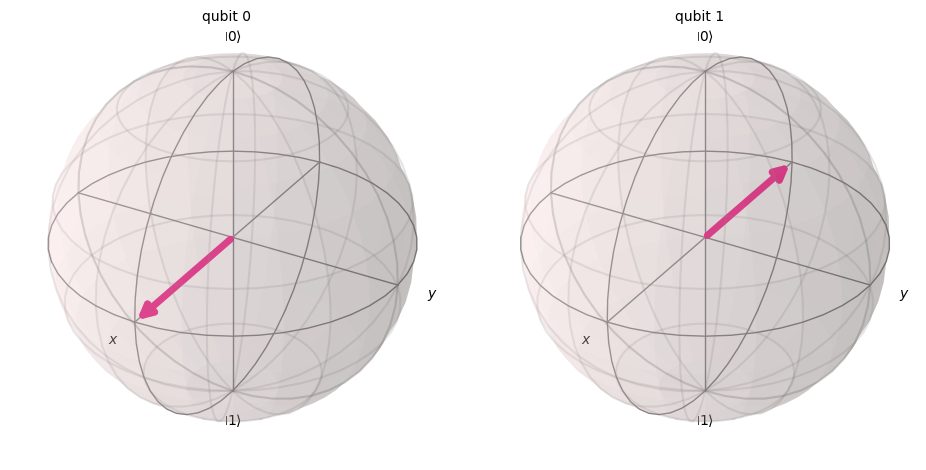

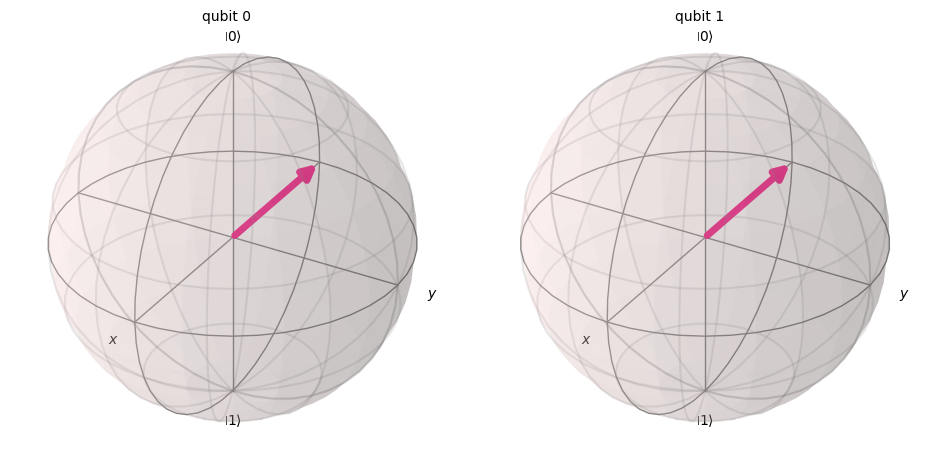

     ┌───┐┌───┐     ┌───┐┌───┐┌─┐
q_0: ┤ H ├┤ X ├──■──┤ X ├┤ H ├┤M├
     ├───┤├───┤┌─┴─┐└───┘└───┘└╥┘
q_1: ┤ X ├┤ H ├┤ X ├───────────╫─
     └───┘└───┘└───┘           ║ 
c: 1/══════════════════════════╩═
                               0 

Measurement results: {'1': 1024}
→ Function is BALANCED.


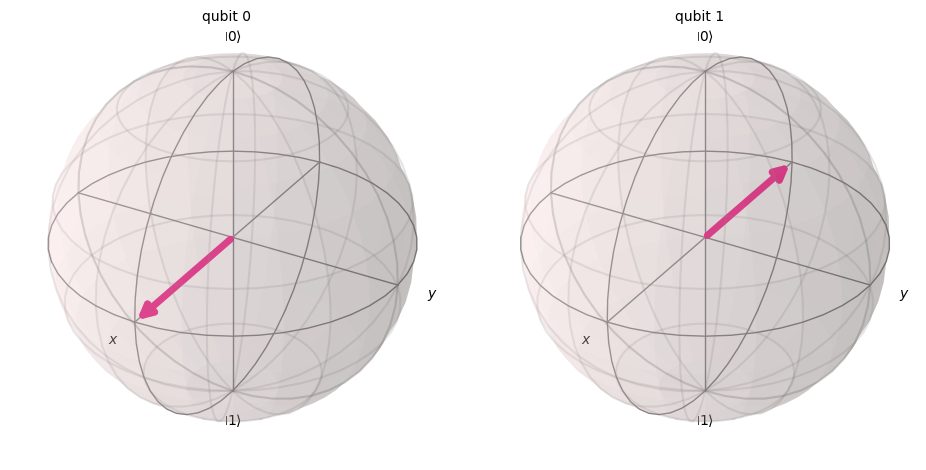

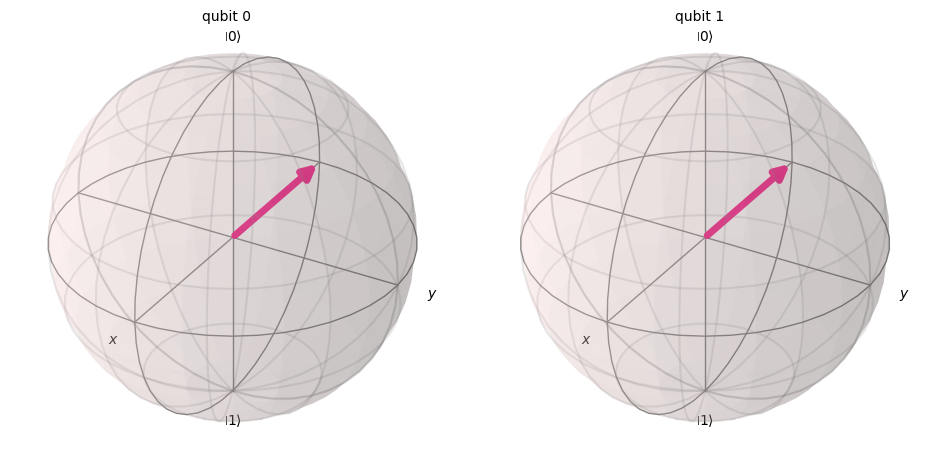

In [ ]:
%matplotlib inline
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Statevector
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_bloch_multivector

function_type = 'xor_1'

def deutsch_oracle(qc, function_type):
    if function_type == 'xor_1':
        qc.x(0)
        qc.cx(0, 1)
        qc.x(0)

qc = QuantumCircuit(2, 1)
qc.x(1)
# Applying Hadamard gates
qc.h([0, 1])
# Plotting Bloch sphere after Hadamard
state_after_h = Statevector(qc)
display(plot_bloch_multivector(state_after_h))

deutsch_oracle(qc, function_type)
state_after_oracle = Statevector(qc)
display(plot_bloch_multivector(state_after_oracle))

qc.h(0)
qc.measure(0, 0)

sim = AerSimulator()
qc_compiled = transpile(qc, sim)
result = sim.run(qc_compiled).result()
counts = result.get_counts()

print(qc.draw(output="text"))
print("\nMeasurement results:", counts)
print("→ Function is BALANCED.")


In [ ]:
'''
The Bloch sphere visualizations show the state transformations at each step of the Deutsch algorithm for the function f(x) = x XOR 1.
'''

In [ ]:
# Task_3 : Deutsch–Jozsa Extension

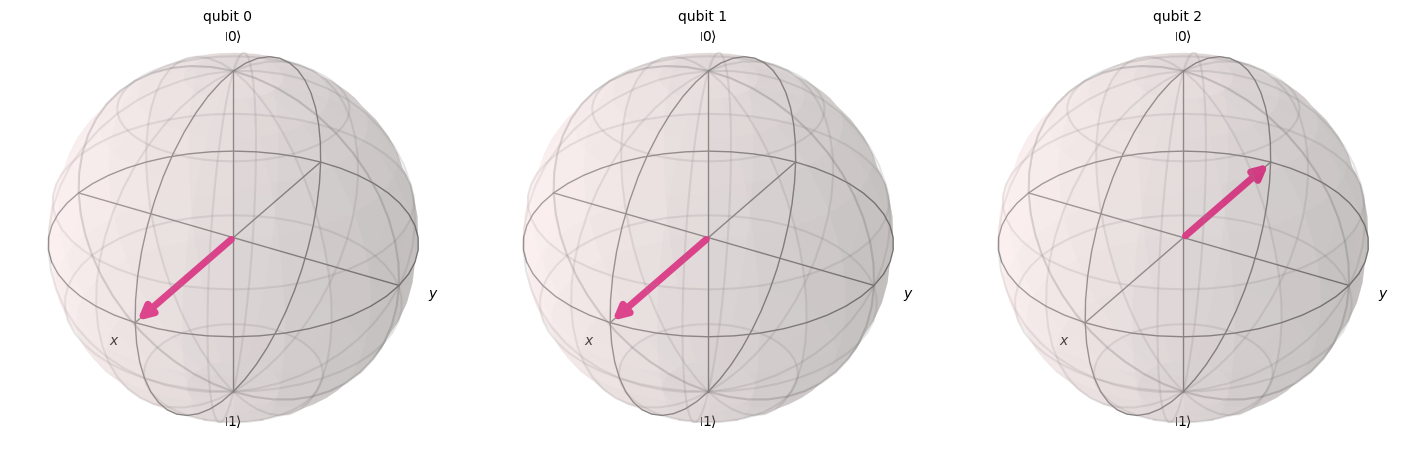

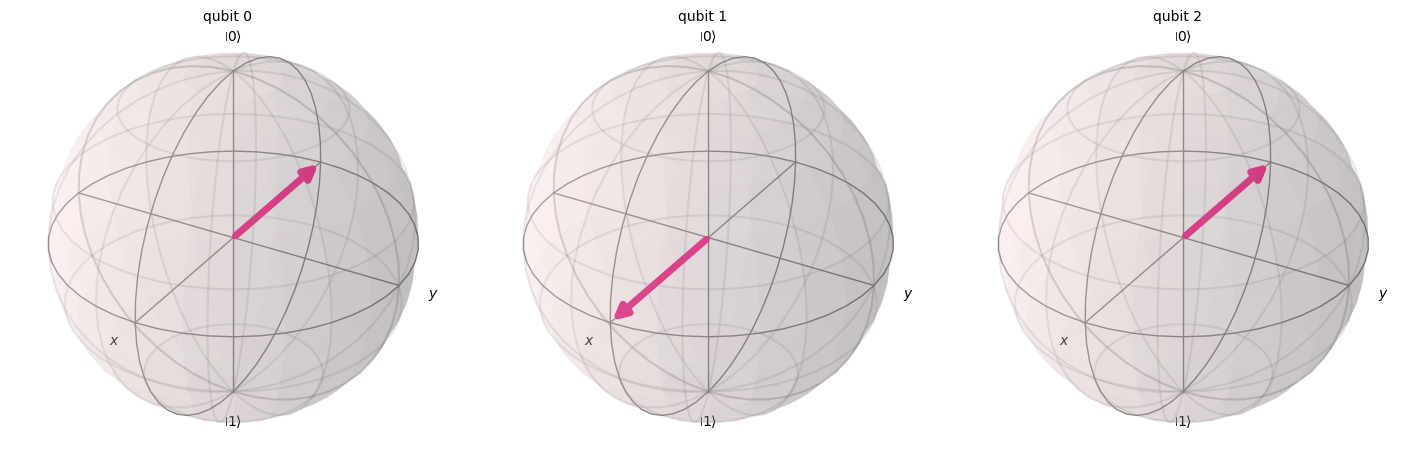

     ┌───┐          ┌───┐┌─┐
q_0: ┤ H ├───────■──┤ H ├┤M├
     ├───┤┌───┐  │  └┬─┬┘└╥┘
q_1: ┤ H ├┤ H ├──┼───┤M├──╫─
     ├───┤├───┤┌─┴─┐ └╥┘  ║ 
q_2: ┤ X ├┤ H ├┤ X ├──╫───╫─
     └───┘└───┘└───┘  ║   ║ 
c: 2/═════════════════╩═══╩═
                      1   0 

Measurement results: {'01': 1024}
→ Function is BALANCED.


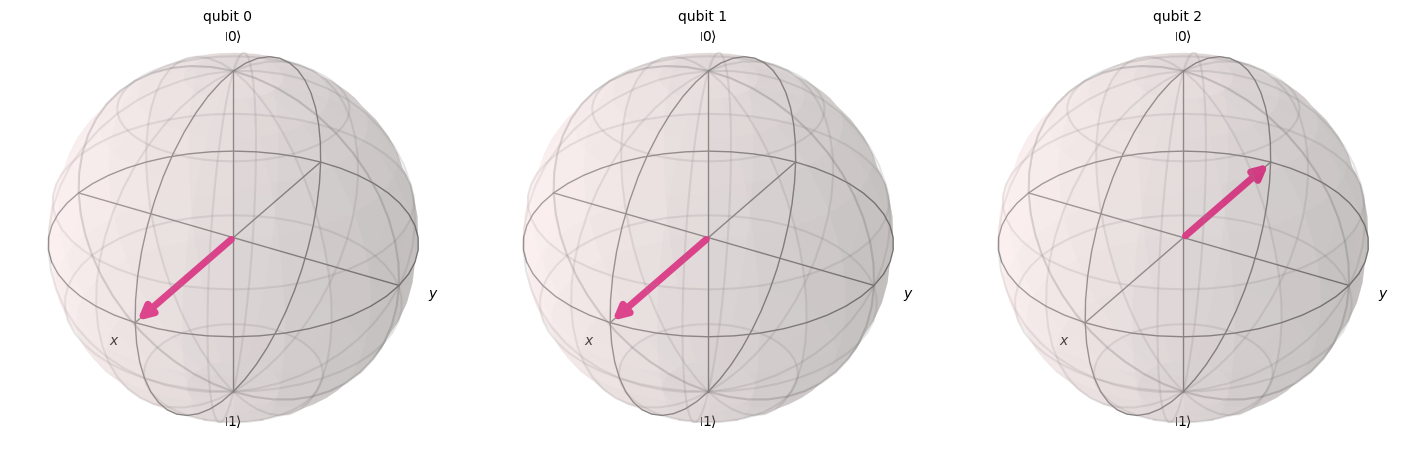

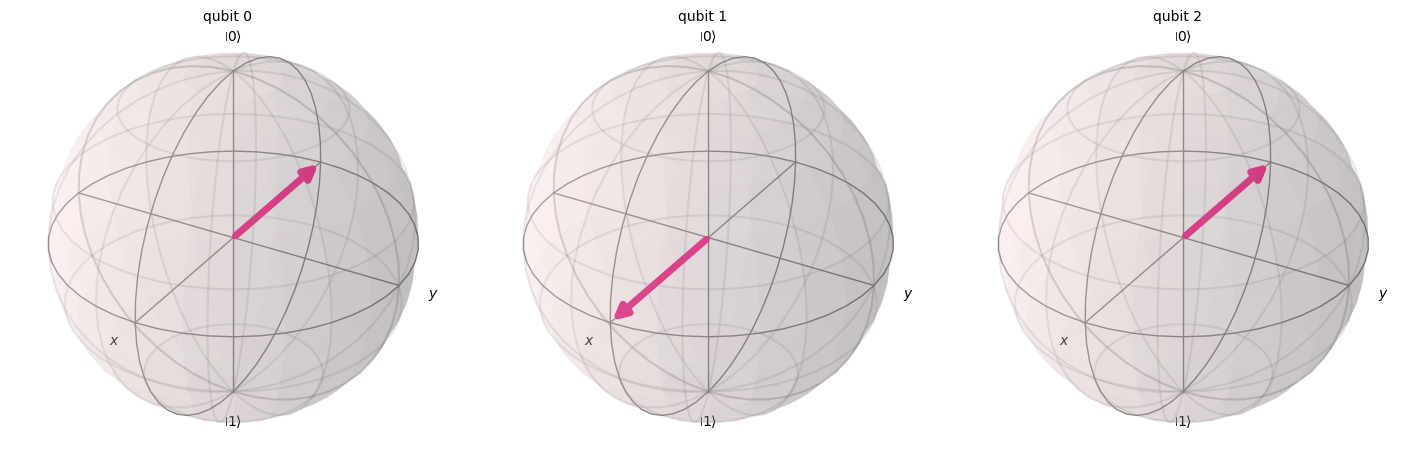

In [12]:
%matplotlib inline
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Statevector
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_bloch_multivector

function_type = 'balanced_1'

def deutsch_jozsa_oracle(qc, function_type):
    if function_type == 'constant_0':
        pass
    elif function_type == 'constant_1':
        qc.x(2)
    elif function_type == 'balanced_1':
        qc.cx(0, 2)
    elif function_type == 'balanced_2':
        qc.cx(1, 2)

# 2 input qubits + 1 output qubit
qc = QuantumCircuit(3, 2)

qc.x(2)
qc.h([0, 1, 2])
state_after_h = Statevector(qc)
display(plot_bloch_multivector(state_after_h))

deutsch_jozsa_oracle(qc, function_type)
state_after_oracle = Statevector(qc)
display(plot_bloch_multivector(state_after_oracle))

qc.h([0, 1])
qc.measure([0, 1], [0, 1])

sim = AerSimulator()
qc_compiled = transpile(qc, sim)
result = sim.run(qc_compiled).result()
counts = result.get_counts()

print(qc.draw(output="text"))
print("\nMeasurement results:", counts)

if list(counts.keys())[0] == '00':
    print("→ Function is CONSTANT.")
else:
    print("→ Function is BALANCED.")


In [ ]:
'''
The Deutsch–Jozsa algorithm with 2 input qubits correctly identifies whether the function is constant or balanced in one evaluation.
'''

In [ ]:
# Task_4 : Noise Impact

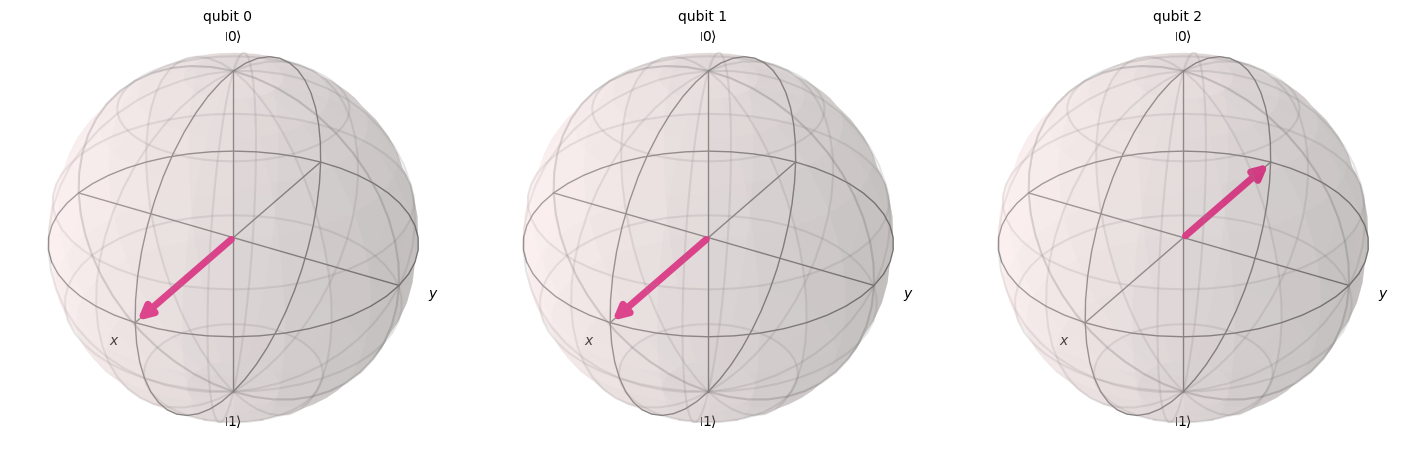

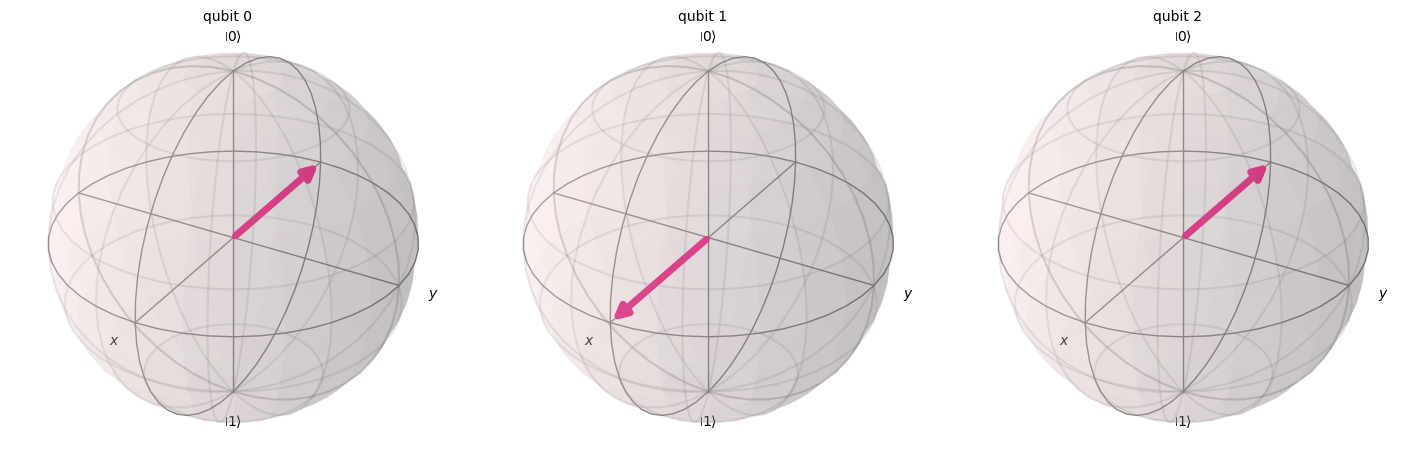

     ┌───┐          ┌───┐┌─┐
q_0: ┤ H ├───────■──┤ H ├┤M├
     ├───┤┌───┐  │  └┬─┬┘└╥┘
q_1: ┤ H ├┤ H ├──┼───┤M├──╫─
     ├───┤├───┤┌─┴─┐ └╥┘  ║ 
q_2: ┤ X ├┤ H ├┤ X ├──╫───╫─
     └───┘└───┘└───┘  ║   ║ 
c: 2/═════════════════╩═══╩═
                      1   0 

Ideal Measurement Results: {'01': 1024}
Noisy Measurement Results: {'01': 966, '00': 58}
→ Ideal: Function is BALANCED.


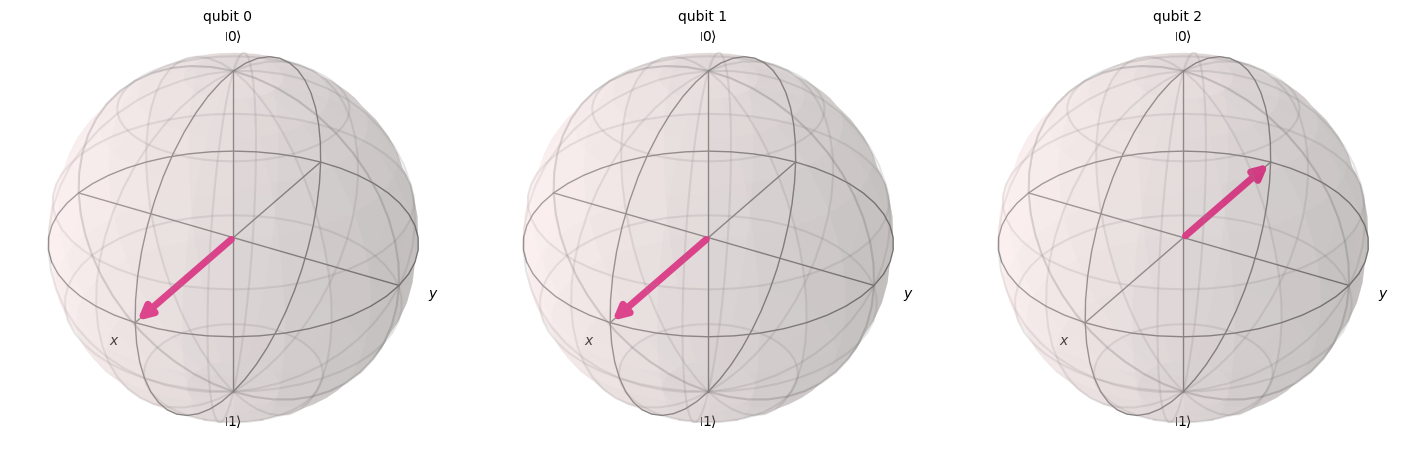

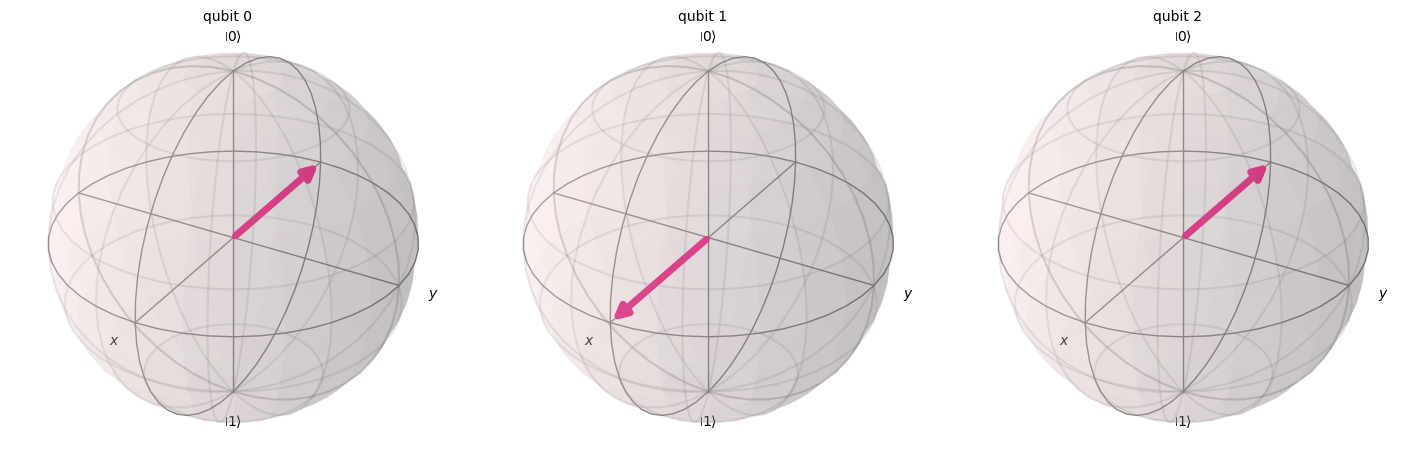

In [13]:
%matplotlib inline
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Statevector
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error, thermal_relaxation_error
from qiskit.visualization import plot_bloch_multivector

function_type = 'balanced_1'

def deutsch_jozsa_oracle(qc, function_type):
    if function_type == 'constant_0':
        pass
    elif function_type == 'constant_1':
        qc.x(2)
    elif function_type == 'balanced_1':
        qc.cx(0, 2)
    elif function_type == 'balanced_2':
        qc.cx(1, 2)

qc = QuantumCircuit(3, 2)

qc.x(2)
qc.h([0, 1, 2])
state_after_h = Statevector(qc)
display(plot_bloch_multivector(state_after_h))

deutsch_jozsa_oracle(qc, function_type)
state_after_oracle = Statevector(qc)
display(plot_bloch_multivector(state_after_oracle))

qc.h([0, 1])
qc.measure([0, 1], [0, 1])

sim = AerSimulator()
qc_compiled = transpile(qc, sim)
result_ideal = sim.run(qc_compiled).result()
counts_ideal = result_ideal.get_counts()

# Define simple noise model
noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(depolarizing_error(0.02, 1), ['x', 'h'])
noise_model.add_all_qubit_quantum_error(depolarizing_error(0.05, 2), ['cx'])

# Noisy simulation
sim_noisy = AerSimulator(noise_model=noise_model)
qc_compiled_noisy = transpile(qc, sim_noisy)
result_noisy = sim_noisy.run(qc_compiled_noisy).result()
counts_noisy = result_noisy.get_counts()

print(qc.draw(output="text"))
print("\nIdeal Measurement Results:", counts_ideal)
print("Noisy Measurement Results:", counts_noisy)

if list(counts_ideal.keys())[0] == '00':
    print("→ Ideal: Function is CONSTANT.")
else:
    print("→ Ideal: Function is BALANCED.")



In [ ]:
'''
With noise, the measurement distribution is distorted — quantum noise causes errors that reduce confidence in detecting the correct function.
'''

In [ ]:
# Task_5 : Compare Classical vs Quantum Queries

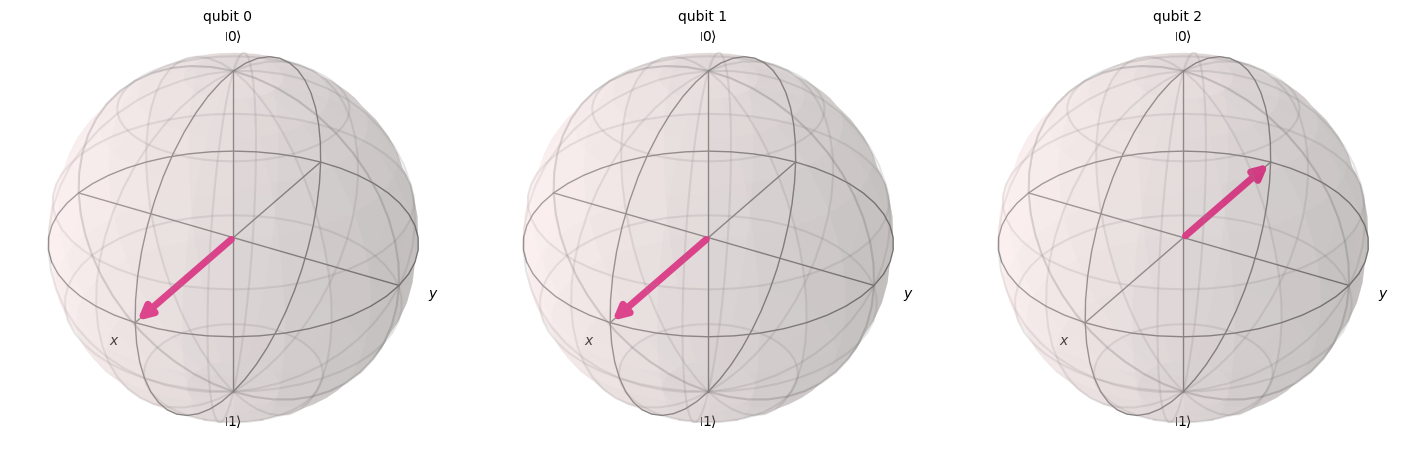

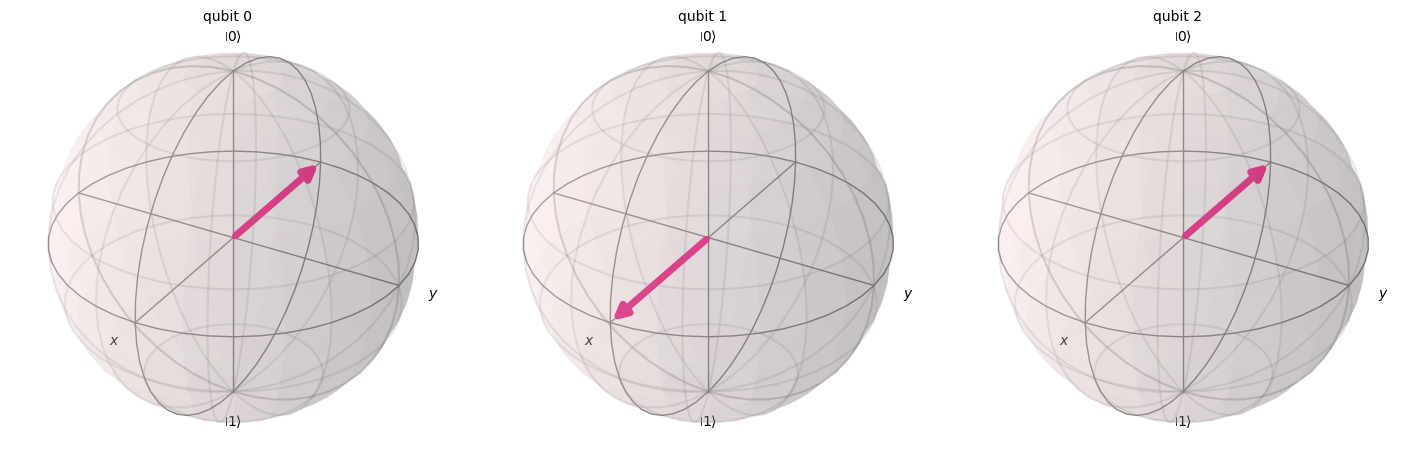

     ┌───┐          ┌───┐┌─┐
q_0: ┤ H ├───────■──┤ H ├┤M├
     ├───┤┌───┐  │  └┬─┬┘└╥┘
q_1: ┤ H ├┤ H ├──┼───┤M├──╫─
     ├───┤├───┤┌─┴─┐ └╥┘  ║ 
q_2: ┤ X ├┤ H ├┤ X ├──╫───╫─
     └───┘└───┘└───┘  ║   ║ 
c: 2/═════════════════╩═══╩═
                      1   0 

Quantum Measurement Results: {'01': 1024}
→ Quantum: Function is BALANCED.
→ Classical: Function is BALANCED (required up to 2 queries).


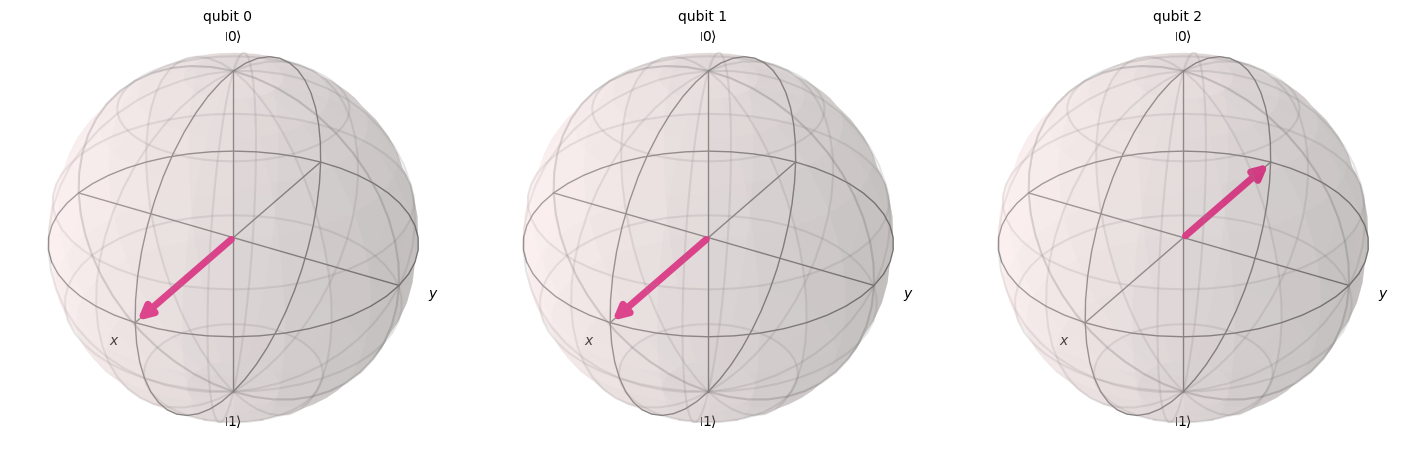

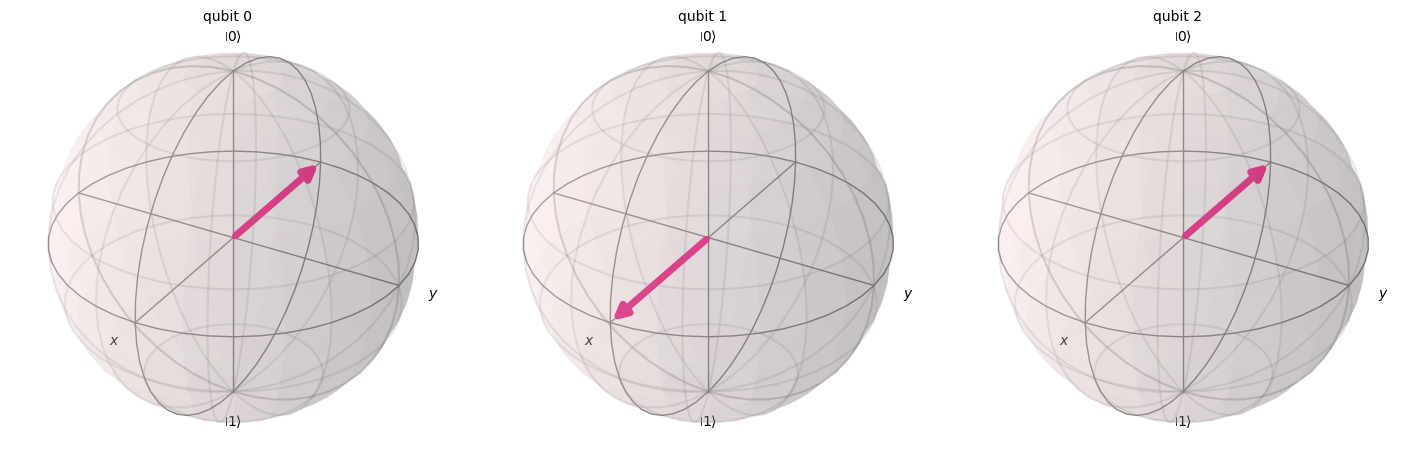

In [14]:
%matplotlib inline
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Statevector
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_bloch_multivector

function_type = 'balanced_1'

def deutsch_jozsa_oracle(qc, function_type):
    if function_type == 'constant_0':
        pass
    elif function_type == 'constant_1':
        qc.x(2)
    elif function_type == 'balanced_1':
        qc.cx(0, 2)
    elif function_type == 'balanced_2':
        qc.cx(1, 2)

qc = QuantumCircuit(3, 2)

qc.x(2)
qc.h([0, 1, 2])
state_after_h = Statevector(qc)
display(plot_bloch_multivector(state_after_h))

deutsch_jozsa_oracle(qc, function_type)
state_after_oracle = Statevector(qc)
display(plot_bloch_multivector(state_after_oracle))

qc.h([0, 1])
qc.measure([0, 1], [0, 1])

sim = AerSimulator()
qc_compiled = transpile(qc, sim)
result = sim.run(qc_compiled).result()
counts = result.get_counts()

print(qc.draw(output="text"))
print("\nQuantum Measurement Results:", counts)

if list(counts.keys())[0] == '00':
    print("→ Quantum: Function is CONSTANT.")
else:
    print("→ Quantum: Function is BALANCED.")

# Classical version
def classical_function(x1, x2, function_type):
    if function_type == 'constant_0':
        return 0
    elif function_type == 'constant_1':
        return 1
    elif function_type == 'balanced_1':
        return x1
    elif function_type == 'balanced_2':
        return x2

inputs = [(0,0), (0,1), (1,0), (1,1)]
outputs = [classical_function(x1, x2, function_type) for x1, x2 in inputs]
unique_outputs = set(outputs)

if len(unique_outputs) == 1:
    print("→ Classical: Function is CONSTANT (required 2 queries).")
else:
    print("→ Classical: Function is BALANCED (required up to 2 queries).")


In [ ]:
'''
Quantum algorithm determines function type in 1 query, while classical approach may require up to 2 queries for 2-bit inputs.
'''